# Optimization of a power system
Student: Bruno Kiyoshi Ynumaru; Prof. Eduardo Camponogara

In this exercise, you will have the opportunity to approximate a nonlinear problem
as a MILP by means of piecewise-linear models. The power system has 3 buses
as depicted in Fig. 1. Buses 1 and 3 have generation units, whereas bus 2 is a
power consumer. This Figures also gives the maximum power generation ($\bar{P_{gi}}$) and
the power consumption ($\bar{P_{di}}$) of each bus i, under low and high demand. The
properties of the transmission lines appear in Table 1, in pu using a 100 MVA basis,
are indicated in the Figure. The parameters are the resistance $r_{i,j}$ , the reactance $x_{i,j}$
and the number of lines installed between buses i and j.


<img src="Figure1.jpg" alt="Drawing" style="width: 400px; margin-left:auto; margin-right:auto"/>

|Line| $r_{i,j}$ (pu)| $x_{i,j}$ (pu)| ni,j|
|----|---------------|---------------|----------|
|1-2 | 0.030         |0.23           |2         |
|1-3 |0.035          | 0.25          |1         |
|2-3 | 0.025         | 0.20          |1         |

A simplified model is adopted for the transmission network, in which:  
•Lines and transformers are represented by their series impedances in per unit:  
\begin{equation}
z_{i,j} = r_{i,j} + jx_{i,j} \space \space (1)
\end{equation}
where ri;j is the resistance and xi;j is the reactance of line (i; j).  
• Voltage magnitudes are fixed at 1:0 pu.  
• Reactive power balance is supposed to be satisfied.  
With these assumptions, active power flows are expressed as  
\begin{equation}
p.flow \space i \rightarrow j : P_{i,j} = g_{i,j}-(g_{i,j} cos\theta_{i,j} + b_{i,j} sin \theta_{i,j}) \space (2a)\\
p.flow \space j \rightarrow i : P_{j,i} = g_{i,j}-(g_{i,j} cos\theta_{i,j} - b_{i,j} sin \theta_{i,j}) \space (2b) 
\end{equation}  
where $gij$ and $b_{ij}$ are, respectively, the series conductance and series susceptance of
line (i, j), $\theta_{i,j} = (\theta_i - \theta_j)$ and $\theta_i$ is the voltage angle of bus i.  
Conductance and susceptance are calculated as follows  
\begin{equation}
g_{i,j}=\frac{r_{i,j}}{(r^2_{i,j}+x^2_{i,j})}\\
b_{i,j}=-\frac{x_{i,j}}{(r^2_{i,j}+x^2_{i,j})}
\end{equation}  
The power injected into bus i is defined as  
\begin{equation}
P_i=\sum_{j \in N_i} n_{i,j}P_{i,j} = \sum_{j \in N_i}n_{i,j}[g_{i,j}-(g_{i,j}cos\theta_{i,j}+b_{i,j}sin\theta_{i,j}])] \space (3)
\end{equation}  
where $N_i$ is the set of neighboring buses of bus i. To ensure energy conservation, the
following equations must also be satisfied  
\begin{equation}
Pg_i=\bar{Pd_i}+P_i \space (4)
\end{equation}  
Aiming to minimize the power loss in transmission, the power-flow optimization problem could be solved:  

\begin{align}
min &\sum_{i \in N} |P_i| \\
s.t:& Pg_i=\bar{Pd_i}+P_i, \\
&P_i=\sum_{j \in N_i} n_{i,j}P_{i,j}, \\
&0 \le Pg_i \le \bar{Pg_i}, \\
&\theta_i \in [\frac{-\pi}{2},\frac{\pi}{2}, i \in N],  \\
&P_{i,j} = g_{i,j}-(g_{i,j} cos\theta_{i,j} + b_{i,j} sin \theta_{i,j}),\\
&\theta_{i,j}=\theta_i-\theta_j, \\
&\theta_{i,j} \in [-\pi,\pi], i \in N, j \in N_i
\end{align}

Tasks:  
• Reformulate the power-flow optimization problem in MILP using the following piecewise-linear models: CC and SOS2.  
• Implement the models in AMPL, choosing a suitable number of breakpoints to induce a good approximation of the power-flow equations. You may plot the piecewise linear approximations for sin $\theta_{i,j}$ and cos $\theta_{i,j}$ in order to show the degree of approximation.  
• Solve the problem for the low and high power demand cases. Present and illustrate the solutions.  

## Optimization problem solution using Gurobi

In [1]:
import gurobipy as gp
from gurobipy import GRB, Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from itertools import combinations
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)

Extract points from non-linear functions:

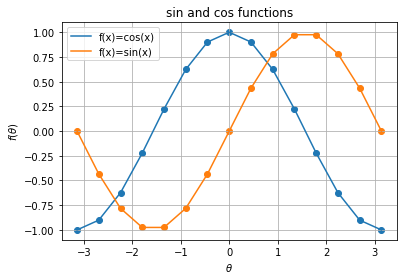

In [2]:
n_points = 15
theta_array = np.linspace(-math.pi,math.pi, n_points)
cos_array = np.cos(theta_array)
sin_array = np.sin(theta_array)
plt.figure()
plt.scatter(theta_array,cos_array)
plt.scatter(theta_array,sin_array)
plt.plot(theta_array,cos_array,label="f(x)=cos(x)")
plt.plot(theta_array,sin_array,label="f(x)=sin(x)")
plt.title("sin and cos functions")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$f(\theta)$')
plt.legend()
plt.grid(which="both")
plt.show()

In [3]:
n_busses = 3
bus_set = [i for i in range(1,n_busses + 1)]
print(bus_set)

[1, 2, 3]


In [4]:
Pd_dict_high = {bus_set[0]:1.0,bus_set[1]:3.5,bus_set[2]:5.0}
Pd_dict_low = {bus_set[0]:1.0,bus_set[1]:2.0,bus_set[2]:3.0}

Pg_dict = {bus_set[0]:7.0,bus_set[1]:0.0,bus_set[2]:4.0}

In [5]:
b_combs = combinations(bus_set,2) # from now on 'b' stands for bus/busses
b_combs = list(b_combs)
print(b_combs)

[(1, 2), (1, 3), (2, 3)]


In [6]:
r_dict = {b_combs[0]:0.30, b_combs[1]:0.35, b_combs[2]:0.35}
x_dict = {b_combs[0]:0.23, b_combs[1]:0.25, b_combs[2]:0.20}
n_dict = {b_combs[0]:2, b_combs[1]:1, b_combs[2]:1}
print(f'r_dict={r_dict}')
print(f'x_dict={x_dict}')
print(f'n_dict={n_dict}')
z = lambda r,x : r + x*1j
z_dict = {bc:z(r_dict[bc], x_dict[bc]) for bc in b_combs}
print(f'z_dict={z_dict}')

r_dict={(1, 2): 0.3, (1, 3): 0.35, (2, 3): 0.35}
x_dict={(1, 2): 0.23, (1, 3): 0.25, (2, 3): 0.2}
n_dict={(1, 2): 2, (1, 3): 1, (2, 3): 1}
z_dict={(1, 2): (0.3+0.23j), (1, 3): (0.35+0.25j), (2, 3): (0.35+0.2j)}


In [7]:
g = lambda r,x: r / (r**2+x**2)
b = lambda r,x: x / (r**2+x**2)

g_dict = {bc:g(r_dict[bc], x_dict[bc]) for bc in b_combs}
b_dict = {bc:b(r_dict[bc], x_dict[bc]) for bc in b_combs}
print(f'g_dict={g_dict}')
print(f'b_dict={b_dict}')

g_dict={(1, 2): 2.099370188943317, (1, 3): 1.8918918918918919, (2, 3): 2.153846153846154}
b_dict={(1, 2): 1.609517144856543, (1, 3): 1.3513513513513513, (2, 3): 1.230769230769231}


In [8]:
# power flow (P) has different values for forwards (f) and backwards (b) directions
Pf = lambda g,b,theta: g - (g*np.cos(theta) + b*np.sin(theta))
Pb = lambda g,b,theta: g - (g*np.cos(theta) - b*np.sin(theta))

Pf_dict = {bc:Pf(r_dict[bc], x_dict[bc], theta_array) for bc in b_combs}
print(f'Pf_dict={Pf_dict}')
Pb_dict = {bc:Pb(r_dict[bc], x_dict[bc], theta_array) for bc in b_combs}
print(f'Pb_dict={Pb_dict}')

Pf_dict={(1, 2): array([ 0.6       ,  0.67008392,  0.66686818,  0.5909897 ,  0.45747714,
        0.2927743 ,  0.1295026 ,  0.        , -0.07008392, -0.06686818,
        0.0090103 ,  0.14252286,  0.3072257 ,  0.4704974 ,  0.6       ]), (1, 3): array([ 0.7       ,  0.77381004,  0.7636793 ,  0.6716143 ,  0.51584965,
        0.32723644,  0.14313183,  0.        , -0.07381004, -0.0636793 ,
        0.0283857 ,  0.18415035,  0.37276356,  0.55686817,  0.7       ]), (2, 3): array([ 0.7       ,  0.75211585,  0.72458773,  0.62286791,  0.46710326,
        0.28814487,  0.12143764,  0.        , -0.05211585, -0.02458773,
        0.07713209,  0.23289674,  0.41185513,  0.57856236,  0.7       ])}
Pb_dict={(1, 2): array([ 0.6       ,  0.4704974 ,  0.3072257 ,  0.14252286,  0.0090103 ,
       -0.06686818, -0.07008392,  0.        ,  0.1295026 ,  0.2927743 ,
        0.45747714,  0.5909897 ,  0.66686818,  0.67008392,  0.6       ]), (1, 3): array([ 0.7       ,  0.55686817,  0.37276356,  0.18415035,  0.0283857 

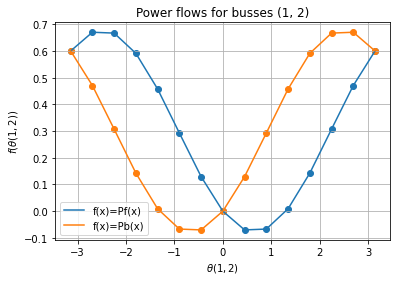

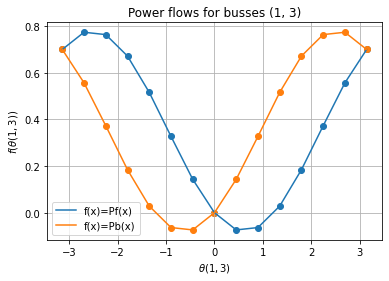

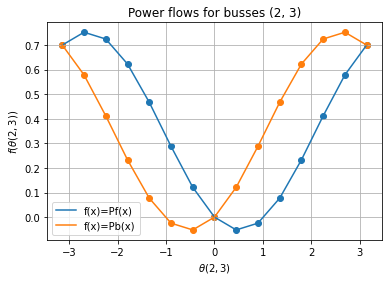

In [9]:
for k, bc in enumerate(b_combs):
    
    plt.figure()
    plt.scatter(theta_array,Pf_dict[bc])
    plt.scatter(theta_array,Pb_dict[bc])
    plt.plot(theta_array,Pf_dict[bc],label="f(x)=Pf(x)")
    plt.plot(theta_array,Pb_dict[bc],label="f(x)=Pb(x)")
    plt.title(f"Power flows for busses {bc}")
    plt.xlabel(fr'$\theta{bc}$')
    plt.ylabel(fr'$f(\theta{bc})$')
    plt.legend()
    plt.grid(which="both")
    plt.show()

In [10]:
P_dict = {}
for bus in bus_set:
    P_dict[bus] = 0
    for pair in b_combs:
        if bus in pair:
            P_dict[bus] += n_dict[pair] * Pf_dict[pair]
    print(f"P_{bus}", P_dict[bus])

P_1 [ 1.9         2.11397788  2.09741566  1.8535937   1.43080393  0.91278504
  0.40213703  0.         -0.21397788 -0.19741566  0.0464063   0.46919607
  0.98721496  1.49786297  1.9       ]
P_2 [ 1.9         2.09228369  2.05832409  1.80484731  1.38205753  0.87369347
  0.38044284  0.         -0.19228369 -0.15832409  0.09515269  0.51794247
  1.02630653  1.51955716  1.9       ]
P_3 [ 1.4         1.52592589  1.48826703  1.29448221  0.98295291  0.61538131
  0.26456948  0.         -0.12592589 -0.08826703  0.10551779  0.41704709
  0.78461869  1.13543052  1.4       ]


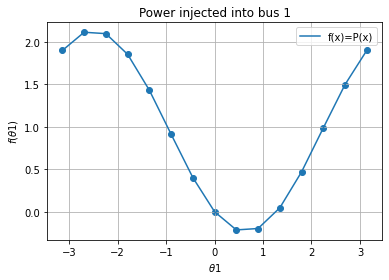

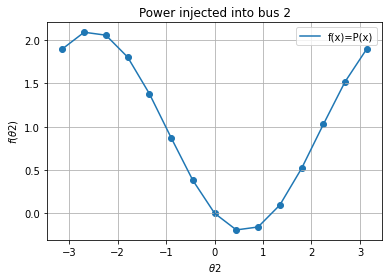

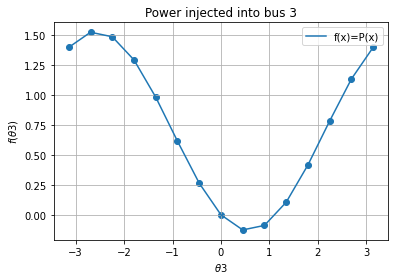

In [11]:
for i, bus in enumerate(bus_set):
    plt.figure()
    plt.scatter(theta_array,P_dict[bus])
    plt.plot(theta_array,P_dict[bus],label="f(x)=P(x)")
    plt.title(f"Power injected into bus {bus}")
    plt.xlabel(fr'$\theta{bus}$')
    plt.ylabel(fr'$f(\theta{bus})$')
    plt.legend()
    plt.grid(which="both")
    plt.show()

## Modeling and solving the problem using Gurobi:
### CC

In [12]:
m = Model()
theta = m.addVars(b_combs, lb=-math.pi, ub=math.pi, vtype=GRB.CONTINUOUS, name="theta")

lambdas = {}
# This creates the piecewise linear reformulations for each pair into our model object
pwlf = {}
# for pair in b_combs:
#     pwlf[pair] = m.addGenConstrPWL(theta[pair], Qoil[pair], data[n][0], data[n][1], f"Qoil(Qinj) well {n}")
    


Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-20


### Modeling the SOS2 constraint in linear terms

\begin{equation} 
\lambda_i^n \in [ 0, +\infty ], i = 0,...,{N_{points}-1} \\
z_i^n \in \{0,1\} , i = 0,...,{N_{points}-1} \\
\lambda_i^n \le z_i , i = 0,...,{N_{points}-1} \\
\sum_{i=0}^{P^n-1} z_i \le 2 \\
z_i^n + z_j^n \le 1, (i,j) \in \{i+2,...,{N_{points}-1}\}^2
\end{equation}